In [2]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
from help_function import *
warnings.filterwarnings('ignore')

In [4]:
data_path = save_path+'\data_class.csv'
origin_data = pd.read_csv(data_path,)  
cols = origin_data.columns.values.tolist()

In [6]:

dataset = origin_data.drop(useless_columns, axis=1)  # 数据
dataset_cols = dataset.columns.values.tolist()
#label = origin_data["na2"].values  # 标签 
# 统计低钠、正常、高钠样本
na = dataset['na2']
origin_low_na_sum = dataset[na<135].shape[0]
origin_normal_na_sum = dataset[na>=135][na<=145].shape[0]
origin_high_na_sum = dataset[na>145].shape[0]
print('低钠血症：%s\n正常血钠：%s\n高钠血症：%s'%(origin_low_na_sum,origin_normal_na_sum,origin_high_na_sum))
#平衡化
from imblearn.under_sampling import RandomUnderSampler
dataset1 = dataset.drop(['class'], axis=1)  # 数据
data_cols = dataset1.columns.values.tolist()

class0 = origin_data["class"].values
rus=RandomUnderSampler(ratio={0:4007,1:4200,2:4201},random_state=42)
x_rus,class_rus=rus.fit_sample(dataset1,class0)
x_rus = pd.DataFrame(x_rus,columns=data_cols)
dataset = x_rus.drop(['na2'], axis=1)
dataset_cols = dataset.columns.values.tolist()
label = x_rus['na2'].values

低钠血症：4007
正常血钠：26374
高钠血症：4201


In [8]:
#标准化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit_transform(dataset)
dataset_new = pd.DataFrame(ss,columns=dataset_cols)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset_new, label, test_size=0.25, random_state=42)
# print(X_train.dtypes)
#num_col = findnum(X_train,dataset_cols)

In [10]:
def model_score(model, model_name):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(model_name + " model R^2:%s" % r2)
    print(model_name + " model RMSE:%s" % rmse)
    print(model_name + " model MAE:%s" % mae)
    return r2,rmse,mae


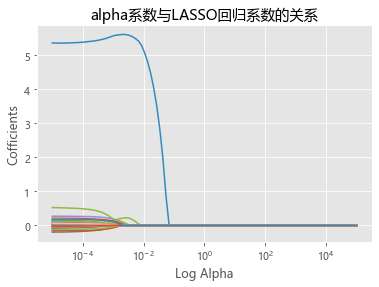

In [11]:

from sklearn.linear_model import Lasso, LassoCV
alphas = 10 ** np.linspace(-5, 5, 100)
lasso_cofficients = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, normalize=True, max_iter=10000)
    lasso.fit(X_train, y_train)
    lasso_cofficients.append(lasso.coef_)
# alpha & coeff of LASSO regression
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
# ploting style
plt.style.use('ggplot')
plt.plot(alphas, lasso_cofficients)
plt.xscale('log')
plt.axis('tight')
plt.title('alpha系数与LASSO回归系数的关系')
plt.xlabel('Log Alpha')
plt.ylabel('Cofficients')
plt.grid(True)
plt.show()


LASSO回归最佳alpha:0.00020565123083486514
LASSO回归R^2:0.7914384413530795
LASSO回归RMSE:3.169072548277428
LASSO回归MAE:2.3824283675444144
['hematocrit', 'na_avg', 'Nacl', 'nephrotoxic drug', 'creatinine', 'ICU type', 'heart rate', 'respiratory rate', 'PO2', 'ICU first weight', 'diuretic drug', 'WBC count', 'age', 'sedative drug', 'gcs score', 'na_max', 'calcium', 'ptt', 'calculated total CO2', 'potassium', 'urine output', 'urea nitrogen', 'magnesium', 'glucose', 'chloride', 'na1']
[0.001, 0.01, 0.013, 0.017, 0.017, 0.019, 0.024, 0.033, 0.033, 0.038, 0.044, 0.051, 0.056, 0.101, 0.103, 0.112, 0.118, 0.14, 0.154, 0.157, 0.166, 0.185, 0.191, 0.255, 0.454, 5.407]


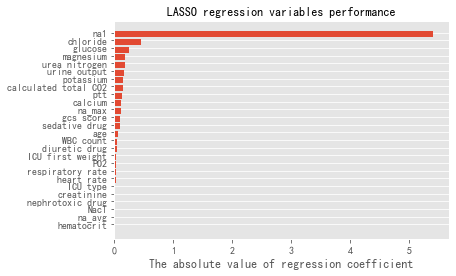

Lasso model:  5.407 * na1 + 0.454 * chloride + 0.255 * glucose + 0.191 * magnesium + 0.185 * urea nitrogen + 0.166 * urine output + -0.157 * potassium + 0.154 * calculated total CO2 + -0.14 * ptt + 0.118 * calcium + 0.112 * na_max + -0.103 * gcs score + 0.101 * sedative drug + 0.056 * age + -0.051 * WBC count + 0.044 * diuretic drug + 0.038 * ICU first weight + -0.033 * PO2 + 0.033 * respiratory rate + 0.024 * heart rate + 0.019 * ICU type + -0.017 * creatinine + -0.017 * nephrotoxic drug + -0.013 * Nacl + 0.01 * na_avg + 0.001 * hematocrit + -0.0 * gender + -0.0 * ICU stay days + 0.0 * na_min + 0.0 * platelet count + -0.0 * PH + 0.0 * phosphate + -0.0 * pt + -0.0 * INR(PT) + 0.0 * temperature + 0.0 * systolic pressure + 0.0 * diastolic pressure


In [12]:

# cross validation of LASSO regression
lasso_cv = LassoCV(alphas=alphas, normalize=True, cv=10, max_iter=10000)
lasso_cv.fit(X_train, y_train)
# optimal alpha
lasso_best_alpha = lasso_cv.alpha_
print("LASSO回归最佳alpha:%s" % lasso_best_alpha)
# building model based on optimal alpha
lasso = Lasso(alpha=lasso_best_alpha, normalize=True, max_iter=10000)
lasso.fit(X_train, y_train)

# lasso.coef_
# print('LASSO回归系数:%s' %lasso.coef_)
# predicting
lasso_predict = lasso.predict(X_test)
r2_score_lasso = r2_score(y_test, lasso_predict)
# score = lasso.score(X_test,y_test)
print('LASSO回归R^2:%s' % r2_score_lasso)
# metrics
RMSE = np.sqrt(mean_squared_error(y_test, lasso_predict))
print('LASSO回归RMSE:%s' % RMSE)
MAE = mean_absolute_error(y_test, lasso_predict)
print('LASSO回归MAE:%s' % MAE)

ranks = {}

def rank_to_dict(ranks, names, order=1):
    #minmax = MinMaxScaler()
    #ranks = minmax.fit_transform(order * np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 3), ranks)
    return dict(zip(names, ranks))

ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), X_test.columns.values)
# import operator
# sorted(d.items(), key=operator.itemgetter(1))
rank = sorted(ranks["Lasso"].items(), key=lambda item: item[1], reverse=True)
# print(rank)
# true and predicting
# plt.figure(figsize=(20, 10))
# plt.figure()
# plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
# plt.rcParams['axes.unicode_minus'] = False
# plt.style.use('ggplot')
# plt.plot(range(len(y_test)), y_test, color='red', label='true_label')
# plt.plot(range(len(y_test)), lasso_predict, color='black', label='predict_label')
# plt.legend(loc='upper left')
# plt.xlabel('sample_point')
# plt.ylabel('curve_comparision')
# plt.show()

# feature selection
import matplotlib.pyplot as plt
# from matplotlib import cm
import numpy as np

keys = []
values = []
for i in range(len(rank)):
    keys.append(rank[i][0])
    values.append(rank[i][1])
    
count = np.sum(np.abs(lasso.coef_)>0.001)
label = keys[:count]
label = label[::-1]
print(label)
x = sorted(values[:count])
print(x)
idx = np.arange(len(x))
#plt.figure(figsize=(20, 10))
#plt.rcParams['figure.dpi'] = 300 #分辨率
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.style.use('ggplot')
plt.barh(idx, x)
plt.yticks(idx + 0.2, label,fontsize=10)
plt.grid(axis='x')
# 设置刻度字体大小
plt.xticks(fontsize=10)
plt.xlabel('The absolute value of regression coefficient')
#plt.ylabel('variables')
plt.title('LASSO regression variables performance',fontsize=12)
plt.savefig(save_path+'\lasso.png',dpi=300,bbox_inches = 'tight')
plt.show()

print("Lasso model: ", pretty_print_linear(lasso.coef_, X_test.columns.values, sort = True))


In [13]:
count = np.sum(np.abs(lasso.coef_)>0)
useless_feature = label[:-count]
use = label[-count:]
X_train = X_train[use]
X_test = X_test[use]
feature_cols = X_train.columns.values.tolist()


In [14]:
# 建立随机森林模型
rf_model = RandomForestRegressor(max_depth=18, max_features=0.271,
                      n_estimators=145, random_state=42)
rf_model.fit(X_train, y_train)
model_score(rf_model, "random-forest")
feature_importances_rf = rf_model.feature_importances_
index = X_train.columns.values.tolist()
print(sorted(zip(map(lambda x: round(x, 15), rf_model.feature_importances_), dataset_cols), reverse=True))


random-forest model R^2:0.8251823077000764
random-forest model RMSE:2.901400897307645
random-forest model MAE:2.1065379854000654
[(0.339198949628302, 'calculated total CO2'), (0.222315464835833, 'gender'), (0.176545155651165, 'calcium'), (0.064219875448331, 'WBC count'), (0.021941933203749, 'phosphate'), (0.016536705512069, 'ptt'), (0.012681364728916, 'pt'), (0.011555247876797, 'INR(PT)'), (0.011315659885628, 'chloride'), (0.010577278560757, 'creatinine'), (0.010480130073085, 'ICU stay days'), (0.009827673692314, 'age'), (0.009661850542424, 'na_avg'), (0.009563623800049, 'glucose'), (0.009456472362853, 'hematocrit'), (0.00887071756717, 'platelet count'), (0.008399073636255, 'PH'), (0.00836674165164, 'na_min'), (0.008346343087422, 'PO2'), (0.008253350405276, 'ICU first weight'), (0.007381878173698, 'magnesium'), (0.00722477168571, 'na1'), (0.003549549223398, 'na_max'), (0.001505638195833, 'urea nitrogen'), (0.001317919177932, 'ICU type'), (0.000906631393394, 'potassium')]


In [15]:
lgb_model = LGBMRegressor(learning_rate=0.071, max_depth=11,
              max_features=0.147, min_samples_split=18,
              n_estimators=203, random_state=42)
lgb_model.fit(X_train, y_train)
lgb_predict = lgb_model.predict(X_test)
model_score(lgb_model, "lightgbm")
lgb_model.feature_importances_
# explainer = shap.TreeExplainer(lgb_model)
# shap_values = explainer.shap_values(X_test)  # 传入特征矩阵X，计算SHAP值
# shap.summary_plot(shap_values, X_test, plot_type="bar")
# shap.summary_plot(shap_values, X_test)


lightgbm model R^2:0.8227931999541187
lightgbm model RMSE:2.92115930071308
lightgbm model MAE:2.141810850595761


array([271, 143, 194,  38, 302,  73, 219, 327, 227, 309,  10, 326, 241,
        36, 207, 155, 255, 219, 181, 271, 357, 348, 260, 391, 274, 447])

In [16]:
xgb_model = XGBRegressor(learning_rate=0.049, max_depth=10,
             max_features=0.332, min_samples_split=2,
             n_estimators=175, 
             # reg_alpha=0.785,
             # reg_lambda=0.752,
             random_state=42)
xgb_model.fit(X_train, y_train)
model_score(xgb_model, "xgboost")
xgb_model.feature_importances_

# plt.rcParams["font.sans-serif"] = ["SimHei"]
# plt.rcParams["axes.unicode_minus"] = False  # 解决作图中文不显示的问题
# explainer = shap.TreeExplainer(xgb_model)
# shap_values = explainer.shap_values(X_test)  # 传入特征矩阵X，计算SHAP值
# shap.summary_plot(shap_values, X_test, plot_type="bar")
# shap.summary_plot(shap_values, X_test)
# from xgboost import plot_importance
# plot_importance(xgb_model)
# plt.show()


[19:53:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgboost model R^2:0.8216319466439301
xgboost model RMSE:2.9307149912339767
xgboost model MAE:2.14612917282134


array([0.00199346, 0.00637326, 0.00346054, 0.0024995 , 0.00412359,
       0.00393939, 0.00428967, 0.00406053, 0.00385619, 0.0047813 ,
       0.00452892, 0.00483563, 0.00503307, 0.00445774, 0.00497191,
       0.01090312, 0.00493373, 0.00464133, 0.00509907, 0.00526947,
       0.00556798, 0.00608801, 0.00539493, 0.00571332, 0.00680599,
       0.87637836], dtype=float32)

In [17]:
cat_model = CatBoostRegressor(n_estimators=199,
                              silent=True,
                              learning_rate=0.08,
                              max_depth=13,
                              random_state=42)
cat_model.fit(X_train, y_train)
model_score(cat_model, "catboost")
cat_model.feature_importances_


catboost model R^2:0.8238349035609501
catboost model RMSE:2.9125606820760868
catboost model MAE:2.134004610901103


array([ 2.91442137,  3.80947791,  3.18971977,  1.97577002,  3.00226037,
        2.65900456,  2.1478082 ,  4.31958442,  2.25616736,  3.74834026,
        0.48316898,  4.46722113,  3.06807503,  1.82502269,  2.19464711,
        2.84374368,  2.85658596,  2.91571725,  2.62522119,  3.98685985,
        3.69212992,  3.51837887,  3.46971273,  4.86250465,  2.81947198,
       24.34898475])

-0.19983589442439653 2.878630854926611


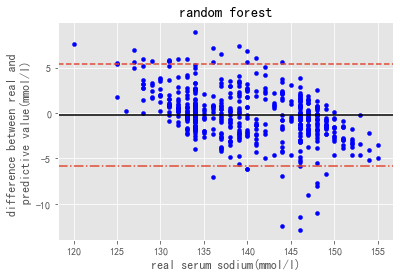

-0.21408183288574217 2.9403853229974604


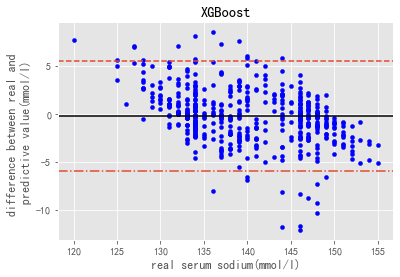

-0.17593712747821544 2.9411387036576238


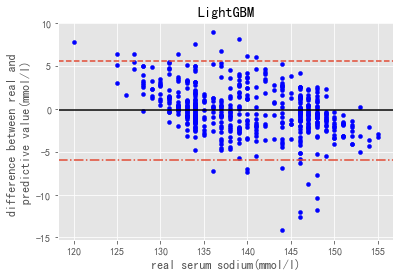

-0.21354541178024963 2.904862901365213


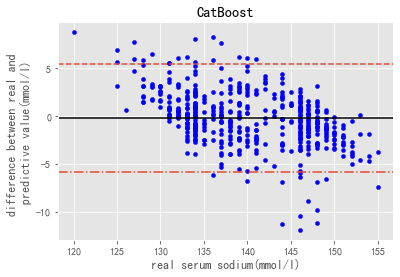

In [18]:
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1 = np.asarray(data1)
    data2 = np.asarray(data2)
    #mean = np.mean([data1, data2], axis=0)
    mean = data2
    diff = data1 - data2                   # Difference between data1 and data2
    md = np.mean(diff)                   # Mean of the difference
    sd = np.std(diff, axis=0)            # Standard deviation of the difference
    print(md,sd)
    plt.scatter(mean, diff,c='b',s=16)
    plt.axhline(md, color='k', linestyle='-')
    plt.axhline(md + 1.96*sd,linestyle='--')
    plt.axhline(md - 1.96*sd, linestyle='-.')
    plt.xlabel('real serum sodium(mmol/l)')
    plt.ylabel('difference between real and \npredictive value(mmol/l)')
    # plt.text(160,-15,'—— mean')
    # plt.text(160,-17,'-- mean+1.96SD')
    # plt.text(160,-19,'-. mean-1.96SD')
    # plt.text(160,-21,'. differences')
    plt.title(*args)
    plt.show()
    
import random
resultList=random.sample(range(0,len(y_test)),500); # sample(x,y)函数的作用是从序列x中，随机选择y个不重复的元素。

bland_altman_plot(rf_model.predict(X_test)[resultList],y_test[resultList],'random forest')
bland_altman_plot(xgb_model.predict(X_test)[resultList],y_test[resultList],'XGBoost')
bland_altman_plot(lgb_model.predict(X_test)[resultList],y_test[resultList],'LightGBM')
bland_altman_plot(cat_model.predict(X_test)[resultList],y_test[resultList],'CatBoost')

# #%% 画shap图,xgboost、lightgbm可以立马计算出结果，而GBDT和随机森林需要较长时间
# models = [lgb_model,xgb_model,cat_model,rf_model]
# models_name = ['LightGBM','XGBoost','CatBoost','Random forest']
# for i in range(len(models)):
#     explainer = shap.TreeExplainer(models[i])
#     shap_values = explainer.shap_values(X_test)  # 传入特征矩阵X，计算SHAP值
#     #shap.summary_plot(shap_values, X_test, plot_type="bar")
#     plt.figure()
#     #plt.rcParams['figure.dpi'] = 300 #分辨率
#     plt.title(models_name[i]+' model shap value')
#     shap.summary_plot(shap_values, X_test, show=False)#show=False才可以保存图，因为保存图要在show之前
#     plt.savefig(save_path+'\shap'+models_name[i]+'.png',dpi=300,bbox_inches = 'tight')


In [19]:
rf_r2,rf_rmse,rf_mae = model_score(rf_model, "random-forest")
xgb_r2,xgb_rmse,xgb_mae = model_score(xgb_model, "xgboost")
lgb_r2,lgb_rmse,lgb_mae = model_score(lgb_model, "lightgbm")
cat_r2,cat_rmse,cat_mae = model_score(cat_model, "catboost")
rf_score = [rf_r2,rf_rmse,rf_mae]
xgb_score = [xgb_r2,xgb_rmse,xgb_mae]
lgb_score = [lgb_r2,lgb_rmse,lgb_mae]
cat_score = [cat_r2,cat_rmse,cat_mae]
all_score = pd.DataFrame(np.array([rf_score,xgb_score,lgb_score,cat_score]).T,
                         index=['R2','RMSE','MAE'],
                         columns=['Random forest','XGBoost','LightGBM','CatBoost'])
print(all_score)


random-forest model R^2:0.8251823077000764
random-forest model RMSE:2.901400897307645
random-forest model MAE:2.1065379854000654
xgboost model R^2:0.8216319466439301
xgboost model RMSE:2.9307149912339767
xgboost model MAE:2.14612917282134
lightgbm model R^2:0.8227931999541187
lightgbm model RMSE:2.92115930071308
lightgbm model MAE:2.141810850595761
catboost model R^2:0.8238349035609501
catboost model RMSE:2.9125606820760868
catboost model MAE:2.134004610901103
      Random forest   XGBoost  LightGBM  CatBoost
R2         0.825182  0.821632  0.822793  0.823835
RMSE       2.901401  2.930715  2.921159  2.912561
MAE        2.106538  2.146129  2.141811  2.134005


In [20]:

rf_feature = sorted(zip(map(lambda x: round(x, 3), rf_model.feature_importances_), feature_cols), reverse=True)
xgb_feature = sorted(zip(map(lambda x: round(x, 3), xgb_model.feature_importances_), feature_cols), reverse=True)
lgb_feature = sorted(zip(map(lambda x: round(x, 3), lgb_model.feature_importances_), feature_cols), reverse=True)
cat_feature = sorted(zip(map(lambda x: round(x, 3), cat_model.feature_importances_), feature_cols), reverse=True)

rf_fea,xgb_fea,lgb_fea,cat_fea = [],[],[],[]
for i in range(len(rf_feature)):
    rf_fea.append(rf_feature[i][1])
    xgb_fea.append(xgb_feature[i][1])
    lgb_fea.append(lgb_feature[i][1])
    cat_fea.append(cat_feature[i][1])
lasso_feature = label[:count]
lasso_feature.reverse()
all_feature_importances = pd.DataFrame(np.array([lasso_feature, rf_fea,xgb_fea,lgb_fea,cat_fea]).T,
                                       columns=['LASSO','Random forest','XGBoost','LightGBM','CatBoost'])

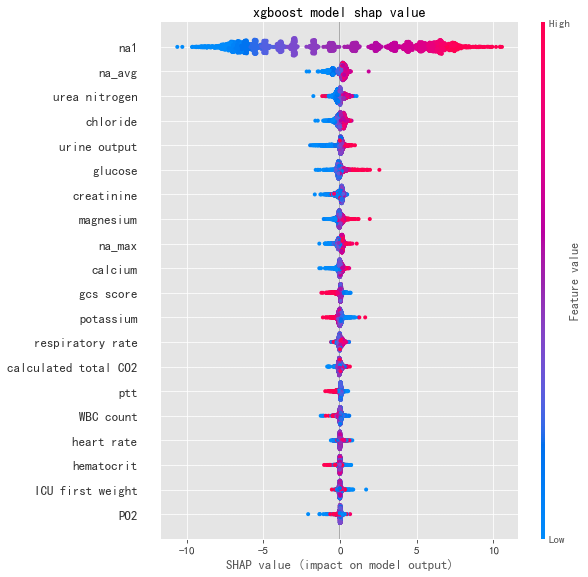

In [21]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)  # 传入特征矩阵X，计算SHAP值
plt.title('xgboost model shap value')
shap.summary_plot(shap_values, X_test, show=False)#show=False才可以保存图，因为保存图要在show之前

In [22]:
shap_values = explainer.shap_values(X_test)  # 传入特征矩阵X，计算SHAP值
if len(shap_values) == 2:
    shap_values = shap_values[1]
plt.savefig(save_path+'\shap.png',dpi=300,bbox_inches = 'tight')

<Figure size 432x288 with 0 Axes>

In [23]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)
plt.savefig(save_path+'\shap2.png',dpi=300,bbox_inches = 'tight')

<Figure size 432x288 with 0 Axes>

In [24]:
i = 5
shap.force_plot(explainer.expected_value, shap_values[i,:], X_test.iloc[i,:])

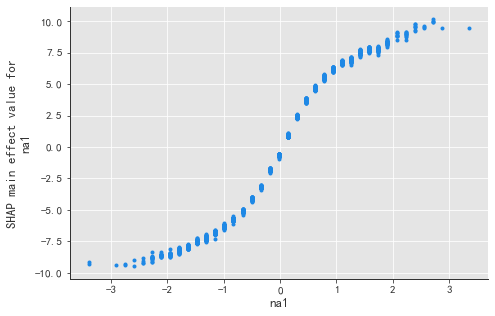

In [25]:
shap_interaction_values = explainer.shap_interaction_values(X_test)
feature_analysis = 'na1'
shap.dependence_plot((feature_analysis, feature_analysis), shap_interaction_values, X_test, interaction_index=None)

In [27]:
#from collections import Counter
im1 = all_feature_importances.values[:5,:].flatten()
im2 = all_feature_importances.values[:10,:].flatten()
im3 = all_feature_importances.values[:15,:].flatten()
im4 = all_feature_importances.values.flatten()
# out = Counter(im)
# print(out)
rank = pd.DataFrame([pd.value_counts(im1),pd.value_counts(im2),pd.value_counts(im3),pd.value_counts(im4)],index=['rank5_count','rank10_count','rank15_count','all_count']).T

all_score.to_csv(save_path+r'\all_score.csv')
all_feature_importances.to_csv(save_path+r'\all_feature_importances.csv')
rank.to_csv(save_path+r'\rank.csv')